<a href="https://colab.research.google.com/github/efandresena/large-scale-movie-recommendation/blob/colab_developement/mirindraf_mlas_practical_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practical 2 : Model with biases only

### Data structure

In [1]:
import random

class Dataset:
    def __init__(self):
        self.userId_to_idx = {}
        self.idx_to_userId = []
        self._data_by_user = []

        self.movieId_to_idx = {}
        self.idx_to_movieId = []
        self._data_by_movie = []

    @property
    def usr_size(self):
        return len(self.idx_to_userId)

    @property
    def movie_size(self):
        return len(self.idx_to_movieId)

    def is_old_user(self, userId):
        return userId in self.userId_to_idx

    def is_old_movie(self, movieId):
        return movieId in self.movieId_to_idx

    def fetch(self, userId, movieId, rating_value, train=True):
        # Ensure user exists
        if not self.is_old_user(userId):
            user_pos = len(self.idx_to_userId)
            self.userId_to_idx[userId] = user_pos
            self.idx_to_userId.append(userId)
            self._data_by_user.append([])
        else:
            user_pos = self.userId_to_idx[userId]

        # Ensure movie exists
        if not self.is_old_movie(movieId):
            movie_pos = len(self.idx_to_movieId)
            self.movieId_to_idx[movieId] = movie_pos
            self.idx_to_movieId.append(movieId)
            self._data_by_movie.append([])
        else:
            movie_pos = self.movieId_to_idx[movieId]

        # Only add rating if this is train/test actual dataset
        if train is not None:
            self._data_by_user[user_pos].append((movie_pos, rating_value))
            self._data_by_movie[movie_pos].append((user_pos, rating_value))

    def __repr__(self):
        return (f"Dataset(users={self.usr_size}, movies={self.movie_size}, "
                f"ratings={sum(len(r) for r in self._data_by_user)})")




### Download Dataset

In [38]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

# Read the file
link = "/content/ml-latest-small/ratings.csv"


### Split test train by rating of each user

In [41]:
import random

# create two instance of the dataset that share the same  structure indexing
train = Dataset()
test = Dataset()
test_ratio = 0.2

with open(link, 'r') as file:
    next(file)  # skip header
    for i, line in enumerate(file):
        # if i >= 202:  # test smaller subset
        #     break
        userId, movieId, rating, _ = line.strip().split(',')
        rating = float(rating)

        # Random split per rating
        if random.random() < test_ratio:
            test.fetch(userId, movieId, rating, train=True)
            train.fetch(userId, movieId, rating, train=None)
        else:
            train.fetch(userId, movieId, rating, train=True)
            test.fetch(userId, movieId, rating, train=None)


# --- Print first 20 ratings per user/movie ---
def inspect_dataset(ds, name):
    print(f"\n{name}: {ds}")
    print("First 20 ratings per user:")
    for u_idx, ratings in enumerate(ds._data_by_user[:20]):
      if u_idx%8==0:
        print(f" User {ds.idx_to_userId[u_idx]}: {ratings[:10]}")
    print("\nFirst 20 ratings per movie:")
    for m_idx, ratings in enumerate(ds._data_by_movie[:20]):
      if u_idx%8==0:
        print(f" Movie {ds.idx_to_movieId[m_idx]}: {ratings[:10]}")


inspect_dataset(train, "Train set")
inspect_dataset(test, "Test set")




Train set: Dataset(users=610, movies=9724, ratings=80805)
First 20 ratings per user:
 User 1: [(0, 4.0), (1, 4.0), (2, 4.0), (3, 5.0), (4, 5.0), (5, 3.0), (7, 4.0), (8, 5.0), (11, 5.0), (12, 3.0)]
 User 9: [(498, 3.0), (12, 4.0), (619, 3.0), (829, 3.0), (830, 4.0), (45, 5.0), (831, 2.0), (832, 4.0), (70, 5.0), (85, 5.0)]
 User 17: [(0, 4.5), (971, 3.5), (7, 4.5), (1093, 4.0), (463, 3.5), (15, 5.0), (588, 3.5), (16, 5.0), (232, 5.0), (20, 5.0)]

First 20 ratings per movie:

Test set: Dataset(users=610, movies=9724, ratings=20031)
First 20 ratings per user:
 User 1: [(6, 5.0), (9, 5.0), (10, 5.0), (13, 5.0), (18, 5.0), (24, 4.0), (28, 5.0), (31, 5.0), (37, 3.0), (50, 5.0)]
 User 9: [(828, 3.0), (841, 3.0), (755, 4.0), (850, 3.0), (853, 1.0), (764, 5.0), (858, 4.0), (860, 4.0)]
 User 17: [(3, 4.0), (4, 4.5), (28, 4.5), (70, 4.5), (1102, 5.0), (1138, 4.0), (267, 4.0), (1139, 3.5), (994, 4.0), (108, 5.0)]

First 20 ratings per movie:


### Power law plot 100K

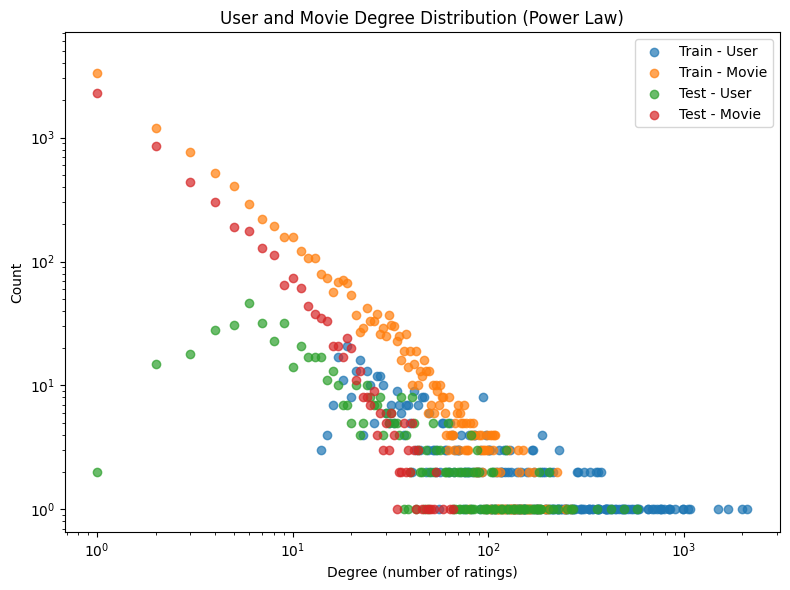

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

for dataset, name in [(train, "Train"), (test, "Test")]:
    user_degree = [len(user) for user in dataset._data_by_user]
    movie_degree = [len(movie) for movie in dataset._data_by_movie]

    unique_u, counts_u = np.unique(user_degree, return_counts=True)
    unique_m, counts_m = np.unique(movie_degree, return_counts=True)

    # Plot user and movie degree distributions
    ax.scatter(unique_u, counts_u, label=f'{name} - User', alpha=0.7)
    ax.scatter(unique_m, counts_m, label=f'{name} - Movie', alpha=0.7)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_title('User and Movie Degree Distribution (Power Law)')
ax.set_xlabel('Degree (number of ratings)')
ax.set_ylabel('Count')
ax.legend()
plt.tight_layout()
plt.savefig("100K_power_law.pdf")
plt.show()


### Model with biases only

In [5]:
data = Dataset()
with open(link, 'r') as file:
    next(file)  # skip header
    for i, line in enumerate(file):
        # if i >= 202:  # test smaller subset
        #     break
        userId, movieId, rating, _ = line.strip().split(',')
        rating = float(rating)
        data.fetch(userId, movieId, rating, train=True)


In [6]:
# metrics function
def compute_metrics(dataset, user_biases, item_biases, gamma, lamda):
    """Compute loss and RMSE for a given dataset."""
    sq_err = 0.0
    count = 0

    for m, user_row in enumerate(dataset._data_by_user):
        for n, r in user_row:
            pred = user_biases[m] + item_biases[n]
            diff = r - pred
            sq_err += diff ** 2
            count += 1

    # Regularized least squares loss
    reg_term = 0.5 * gamma * (user_biases@user_biases + item_biases@item_biases )
    loss = (0.5* lamda * sq_err) + reg_term

    # Root Mean Squared Error
    rmse = np.sqrt(sq_err/count)

    return loss, rmse

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- hyperparams  ---
lamda = 0.1
gamma = 0.1
E = 30

M = len(train._data_by_user)
N = len(train._data_by_movie)

user_biases = np.zeros(M)
item_biases = np.zeros(N)

loss_train, loss_test = [], []
rmse_train, rmse_test = [], []

# --- training loop ---
for epoch in range(E):

    # --- update user biases ---
    for m in range(M):
        bias = 0.0
        item_counter = 0.0
        for (n, r) in train._data_by_user[m]:
            bias += lamda * (r - item_biases[n])
            item_counter += 1.0
        denom = lamda * item_counter + gamma

        user_biases[m] = bias / denom if denom != 0 else 0

    # --- update item biases ---
    for n in range(N):
        bias = 0.0
        user_counter = 0.0
        for (m, r) in train._data_by_movie[n]:
            bias += lamda * (r - user_biases[m])
            user_counter += 1.0
        denom = lamda * user_counter + gamma
        item_biases[n] = bias / denom if denom != 0 else 0

    # compute metrics
    l_tr, r_tr = compute_metrics(train, user_biases, item_biases, gamma, lamda)
    l_te, r_te = compute_metrics(test, user_biases, item_biases, gamma, lamda)

    loss_train.append(l_tr)
    loss_test.append(l_te)
    rmse_train.append(r_tr)
    rmse_test.append(r_te)

    # quick console check
    if epoch % 10 == 0 or epoch == E - 1:
        print(f"Epoch {epoch+1:3d}  Loss(train)={l_tr:.4f} Loss(test)={l_te:.4f}  RMSE(train)={r_tr:.4f}  RMSE(test)={r_te:.4f}")



Epoch   1  Loss(train)=3109.8382 Loss(test)=1284.5677  RMSE(train)=0.8040  RMSE(test)=0.8821
Epoch  11  Loss(train)=2966.2573 Loss(test)=1210.5704  RMSE(train)=0.7896  RMSE(test)=0.8691
Epoch  21  Loss(train)=2956.1902 Loss(test)=1199.1617  RMSE(train)=0.7901  RMSE(test)=0.8700
Epoch  30  Loss(train)=2954.4980 Loss(test)=1196.7656  RMSE(train)=0.7903  RMSE(test)=0.8705


In [8]:
import numpy as np
import matplotlib.pyplot as plt

lambda_list = [0.01, 0.1, 0.5]
gamma_list  = [0.01, 0.1, 0.5]
E = 30

M = len(train._data_by_user)
N = len(train._data_by_movie)

results_loss_train = {}
results_loss_test  = {}
results_rmse_train = {}
results_rmse_test  = {}

for lamda in lambda_list:
    for gamma in gamma_list:

        user_biases = np.zeros(M)
        item_biases = np.zeros(N)

        loss_train = []
        loss_test  = []
        rmse_train = []
        rmse_test  = []

        for epoch in range(E):

            for m in range(M):
                s = 0.0
                c = 0.0
                for (n, r) in train._data_by_user[m]:
                    s += lamda * (r - item_biases[n])
                    c += 1.0
                denom = lamda * c + gamma
                user_biases[m] = s / denom if denom != 0 else 0

            for n in range(N):
                s = 0.0
                c = 0.0
                for (m, r) in train._data_by_movie[n]:
                    s += lamda * (r - user_biases[m])
                    c += 1.0
                denom = lamda * c + gamma
                item_biases[n] = s / denom if denom != 0 else 0

            l_tr, r_tr = compute_metrics(train, user_biases, item_biases, gamma, lamda)
            l_te, r_te = compute_metrics(test,  user_biases, item_biases, gamma, lamda)

            loss_train.append(l_tr)
            loss_test.append(l_te)
            rmse_train.append(r_tr)
            rmse_test.append(r_te)

        key = f"lam={lamda}, gam={gamma}"
        results_loss_train[key] = loss_train
        results_loss_test[key]  = loss_test
        results_rmse_train[key] = rmse_train
        results_rmse_test[key]  = rmse_test


# ---- plots ----

mk = {"marker": "x", "markevery": 3}

plt.figure(figsize=(7,5))
for k in results_loss_train:
    plt.plot(results_loss_train[k], **mk, label=k + " train")
    plt.plot(results_loss_test[k], **mk, linestyle="--", label=k + " test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Bias-only ALS: Train & Test Loss")
plt.legend(fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.savefig("100k_train_test_loss.pdf")
plt.close()

plt.figure(figsize=(7,5))
for k in results_rmse_train:
    plt.plot(results_rmse_train[k], **mk, label=k)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Bias-only ALS: Train RMSE")
plt.legend(fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.savefig("100k_train_rmse.pdf")
plt.close()

plt.figure(figsize=(7,5))
for k in results_rmse_test:
    plt.plot(results_rmse_test[k], **mk, label=k)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Bias-only ALS: Test RMSE")
plt.legend(fontsize=7)
plt.grid(True)
plt.tight_layout()
plt.savefig("100k_test_rmse.pdf")
plt.close()


### Prediction for a dummy user

In [26]:
import numpy as np

def predict_for_new_user(dataset, rated_movieId, rating_value, item_biases):
    """
    Predict ratings for ALL movies for the new user
    """
    n = dataset.movieId_to_idx[rated_movieId]

    N = len(item_biases)

    # Predict all movies: bu + bi
    preds = np.array([item_biases[j] for j in range(N)])


    preds[n] = 5

    return preds

new_user_preds = predict_for_new_user(
    dataset=train,
    rated_movieId='1',
    rating_value=5,
    item_biases=item_biases
)


In [34]:
top_k = np.argsort(new_user_preds)[::-1][:5]
recommended_movieIds = [train.idx_to_movieId[i] for i in top_k]

print("Top recommended movies:", recommended_movieIds)


Top recommended movies: ['1', '5746', '6835', '5181', '6818']


In [35]:
import pandas as pd
link = "/content/ml-latest-small/movies.csv"
movies =  pd.read_csv(link)

# Convert recommended_movieIds to integers
recommended_movieIds_int = [int(mid) for mid in recommended_movieIds]

# Get titles from movies.csv
recommended_movies = movies[movies['movieId'].isin(recommended_movieIds_int)]


# Optional: sort according to recommendation order
recommended_movies = recommended_movies.set_index('movieId').loc[recommended_movieIds_int]

recommended_movies[['title', 'genres']]

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5746,Galaxy of Terror (Quest) (1981),Action|Horror|Mystery|Sci-Fi
6835,Alien Contamination (1980),Action|Horror|Sci-Fi
5181,Hangar 18 (1980),Action|Sci-Fi|Thriller
6818,Come and See (Idi i smotri) (1985),Drama|War


Our model only now that the user like toy story 1. Here we only predict by popularity of the movies and in this dataset these are the popular movies.  More feature will be added to the next approach as the embeddingd of the movies and the user